In [1]:
import re
import os
import time
import random
import requests
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def convert_back(df,building_df, energy_col='meter_reading', site_col='site_id',has_col=False):
    '''
    df.groupby(by='site_id')['meter_reading'].mean() -mean meter reading is 549 without converion, 414 with conversion
    df:dataset with the meter_reading col
    building_df: dataset with the site_id col
    energy_col: meter_reading column name
    site_col: site column name
    has_col: if True, does not append site_col column to main df
    '''
    
    if has_col:
        df.loc[(df['site_id'] == 0) & (df['meter'] == 0), energy_col] = df[(df['site_id'] == 0) & (df['meter'] == 0)][energy_col] * 3.4118
        return df
    else:
        df=df.join(building_df[site_col],how='left',on='building_id')
        df.loc[(df['site_id'] == 0) & (df['meter'] == 0), energy_col] = df[(df['site_id'] == 0) & (df['meter'] == 0)]['meter_reading'] * 3.4118
        return df

In [ ]:
def convert_btu(df,building_df, energy_col='meter_reading', site_col='site_id',has_col=False):
    '''
    df:dataset with the meter_reading col
    building_df: dataset with the site_id col
    energy_col: meter_reading column name
    site_col: site column name
    has_col: if True, does not append site_col column to main df
    '''
    
    if has_col:
        df.loc[(df['site_id'] == 0) & (df['meter'] == 0), energy_col] = df[(df['site_id'] == 0) & (df['meter'] == 0)][energy_col] * 0.2931
        return df
    else:
        df=df.join(building_df[site_col],how='left',on='building_id')
        df.loc[(df['site_id'] == 0) & (df['meter'] == 0), energy_col] = df[(df['site_id'] == 0) & (df['meter'] == 0)]['meter_reading'] * 0.2931
        return df

In [67]:
buildings=pd.read_csv('ashrae-energy-prediction/building_metadata.csv')
submission=pd.read_csv('ashrae-energy-prediction/sample_submission.csv')

In [215]:
wet_train=pd.read_csv('ashrae-energy-prediction/weather_train.csv')
train=pd.read_csv('ashrae-energy-prediction/train.csv')
test=pd.read_csv('ashrae-energy-prediction/test.csv')
wet_test=pd.read_csv('ashrae-energy-prediction/weather_test.csv')

In [41]:
dfs={'buildings':buildings,
     'submission':submission,
     'wet_train':wet_train,
     'wet_test':wet_test,
     'train':train,
     'test':test}
for name,data in dfs.items():
    print('{}: {}'.format(name,data.shape))
    for col in data.columns:
        print('\t{}: {}'.format(col,data[col].isna().sum()))

buildings: (1449, 6)
	site_id: 0
	building_id: 0
	primary_use: 0
	square_feet: 0
	year_built: 774
	floor_count: 1094
submission: (41697600, 2)
	row_id: 0
	meter_reading: 0
wet_train: (139773, 9)
	site_id: 0
	timestamp: 0
	air_temperature: 55
	cloud_coverage: 69173
	dew_temperature: 113
	precip_depth_1_hr: 50289
	sea_level_pressure: 10618
	wind_direction: 6268
	wind_speed: 304
wet_test: (277243, 9)
	site_id: 0
	timestamp: 0
	air_temperature: 104
	cloud_coverage: 140448
	dew_temperature: 327
	precip_depth_1_hr: 95588
	sea_level_pressure: 21265
	wind_direction: 12370
	wind_speed: 460
train: (20216100, 4)
	building_id: 0
	meter: 0
	timestamp: 0
	meter_reading: 0
test: (41697600, 4)
	row_id: 0
	building_id: 0
	meter: 0
	timestamp: 0


In [216]:
wet_test.index=pd.DatetimeIndex(wet_test['timestamp'])
wet_test.drop(labels='timestamp',axis=1,inplace=True)

In [217]:
wet_train.index=pd.DatetimeIndex(wet_train['timestamp'])
wet_train.drop(labels='timestamp',axis=1,inplace=True)

In [143]:
buildings['age']=2019-buildings['year_built']

In [156]:
buildings.loc[buildings['year_built'].isna()]['primary_use'].value_counts()

Education                        223
Office                           194
Entertainment/public assembly    111
Public services                  105
Lodging/residential               62
Other                             19
Healthcare                        15
Services                          10
Parking                            8
Warehouse/storage                  8
Manufacturing/industrial           6
Retail                             4
Food sales and service             4
Technology/science                 3
Utility                            1
Religious worship                  1
Name: primary_use, dtype: int64

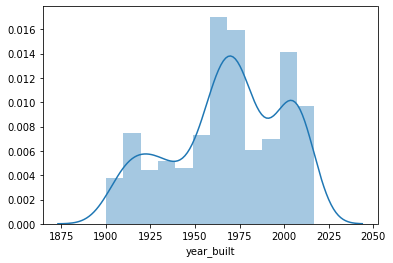

In [146]:
sns.distplot(buildings['year_built'].dropna())

In [125]:
wet_train.loc[wet_train['site_id']==7]['air_temperature'].head(50)

timestamp
2016-01-01 00:00:00   -1.8
2016-01-01 01:00:00   -1.7
2016-01-01 02:00:00   -2.7
2016-01-01 03:00:00   -2.3
2016-01-01 04:00:00   -2.6
2016-01-01 05:00:00   -2.2
2016-01-01 06:00:00   -2.3
2016-01-01 07:00:00   -2.8
2016-01-01 08:00:00   -3.0
2016-01-01 09:00:00   -3.3
2016-01-01 10:00:00   -3.2
2016-01-01 11:00:00   -3.1
2016-01-01 12:00:00   -3.1
2016-01-01 13:00:00   -2.1
2016-01-01 14:00:00   -1.2
2016-01-01 15:00:00   -0.7
2016-01-01 16:00:00   -0.5
2016-01-01 17:00:00   -0.3
2016-01-01 18:00:00   -0.3
2016-01-01 19:00:00   -0.4
2016-01-01 20:00:00   -0.7
2016-01-01 21:00:00   -0.9
2016-01-01 22:00:00   -1.0
2016-01-01 23:00:00   -2.0
2016-01-02 00:00:00   -1.5
2016-01-02 01:00:00   -1.6
2016-01-02 02:00:00   -1.9
2016-01-02 03:00:00   -2.2
2016-01-02 04:00:00   -2.6
2016-01-02 05:00:00   -2.4
2016-01-02 06:00:00   -2.7
2016-01-02 07:00:00   -3.3
2016-01-02 08:00:00   -3.9
2016-01-02 09:00:00   -5.6
2016-01-02 10:00:00   -5.8
2016-01-02 11:00:00   -4.2
2016-01-02 12:00:0

In [193]:
plt.figure(figsize=(15,10))
for k in range(16):
#     print(k)
    wet_train.loc[wet_train['site_id']==k].isna().resample('M').sum().plot(label=k)
# wet_train.loc[wet_train['site_id']==15]['air_temperature'].resample('D').mean().plot(label=15)
plt.legend()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

<Figure size 1080x720 with 0 Axes>

In [196]:
train.index=pd.DatetimeIndex(train['timestamp'])
train=train.drop('timestamp',axis=1)

In [238]:
train['timestamp']=pd.to_datetime(train['timestamp'])

In [240]:
df=pd.merge(train,wet_train[['air_temperature','dew_temperature','wind_speed','site_id','timestamp']],
       left_on=['site_id','timestamp'],
         right_on=['site_id','timestamp'],
        how='left')

In [203]:
wet_train.index=pd.DatetimeIndex(wet_train['timestamp'])
wet_train=wet_train.drop('timestamp',axis=1)

In [208]:
wet_train['timestamp']=wet_train.index

In [213]:
wet_train.drop('timestamp',axis=1,inplace=True)

In [221]:
train=train.join(buildings['site_id'],how='left',on='building_id')

In [257]:
wet_train['timestamp']=pd.to_datetime(wet_train['timestamp'])
df=pd.merge(train,wet_train[['air_temperature','dew_temperature','wind_speed','site_id','timestamp']],
       left_on=['site_id','timestamp'],
         right_on=['site_id','timestamp'],
        how='left')
for col in ['air_temperature','dew_temperature','wind_speed']:
    df[col]=df[col].interpolate()
df.isna().sum()

building_id        0
meter              0
timestamp          0
meter_reading      0
site_id            0
air_temperature    0
dew_temperature    0
wind_speed         0
dtype: int64